In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import datetime
import time
import requests
import time
from typing import List
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from tqdm.notebook import tqdm
from sklearn.cluster import MeanShift, KMeans
from IPython.core.debugger import set_trace
from matplotlib import pyplot, dates

# Loading Data

We need data to analyze. From our milestone we can infer that we will need to be able to get pageviews from both specific articles on Wikipedia, as well as the aggregated pageviews for an entire language project.

### Load our generated list of articles
For our analysis we have aggregated a set of articles representing "Internet software privacy" that we need to analyze. We start out by loading that list of articles:

In [2]:
# load article titles
english_names = pd.read_csv('data/articles.csv', header=None, names=['Title'])

# transform article names so that we can easily query them in the APIs
english_names['Title'] = english_names['Title'].apply(lambda x : x.replace(' ', '_'))
english_names.head()

,Title
0,.i2p
1,.tor
2,2channel
3,420chan
4,4chan


### Retrieve English pageview data 
We now utilize https://www.wikishark.com/ to retrieve the actual page view data for each of the articles on the English language Wikipedia project. We have contacted the developer of this website to grant us the permission to call their backends that we found by doing some 1337 hacking. We are allowed to do so for the "Internet privacy software"-related articles, if we wait 1-2 seconds in between each request.

In [3]:
from typing import Callable

def day_year_to_date(year: int, days: int) -> datetime.datetime:
    """
    Takes the given numerical year and days passed of that year 
    and returns the datetime object representing that date.
    
    :param year: the christian calendar year representing the date wanted
    :param days: the amount of days passed in that year
    
    :returns: datetime object corresponding to the specified date
    """
    return datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)

def get_wikishark_id(article_name: str, language: str) -> str:
    """
    Gives the wikishark internal ID for the given article and language project.
    
    :param article_name: the article title for which the internal ID is requested.
    :param language: the string representing the language project the article title comes from
    
    :returns: string corresponding to the retrieved wikishark ID for the title
    """
    response = requests.get(f'https://www.wikishark.com/autocomplete.php?q={article_name}')
    r = response.json()
    
    target = None
    for candidate in r:
        if '(' + language + ')' in candidate['name'] and article_name.replace('_',' ').lower() in candidate['name'].lower():
            return candidate['id']
    return target

def get_daily_pageviews(titles: List[str], language: str, start: str, end: str, id_provider : Callable[[str,str], str]) -> pd.DataFrame:
    """
    Retrieves the daily page views for the given articles on the given language edition of Wikipedia.
    Filtering is also performed to only return the page views for the given time span.
    
    :param titles: the list of articles to retrieve page views for
    :param language: the string representing the language project the article titlse come from
    
    :returns: DataFrame containing the daily pageviews for the articles in the time span specified
    """
    data = []
    for title in tqdm(titles):
        
        # developer requested we wait 1 second at least in between requests
        time.sleep(1)
        
        # retrieve wikishark ID for article
        wikishark_id = id_provider(title, language)
        if wikishark_id is None:
            print(f'Could not find data for {title}')
            continue
        
        # wait to avoid overloading servers
        time.sleep(1)
        
        # retrieve page views for given title
        response = requests.get(f'https://www.wikishark.com/getdata/daily.php?value={wikishark_id}?view=2&scale=0&normalized=0&loglog=0&log=0&zerofix=0')
        daily_data = response.json()
        
        # add data with timestamps
        start_date = datetime.datetime.strptime(start, '%d/%m/%Y')
        end_date   = datetime.datetime.strptime(end, '%d/%m/%Y')
        current_date = datetime.datetime.now()
        
        # wikishark returns daily page views for every day since 2007-12-31 (independent of given parameters)
        # we need to index it according to the time period we are interested in
        start_index = (len(daily_data) - 1) - (current_date - start_date).days
        end_index = (len(daily_data) - 1) - (current_date - end_date).days
        
        # add page views for each day
        timestamps = {}
        for i, d in enumerate(daily_data[start_index:end_index]):
            ts = start_date + datetime.timedelta(days=i)
            timestamps[ts] = int(d)
    
        # add data for given article to collection
        data.append({**{'Article': title}, **timestamps})
    
    return pd.DataFrame(data)

For this next cell we have made it possible to both regenerate the data set yourself, or just load from the pickled object. Given that we have to wait 1 second in between requests to the wikishark API: we would suggest loading the pickled object.

In [4]:
import os
import re

def retrieve_or_compute_pageviews(articles, language, start, end, id_provider, pickled_file):
    
    # load pickled data if available in root of directory
    if os.path.isfile(pickled_file):
        df = pd.read_pickle(pickled_file)
        
    # reconstruct data from scratch
    else:
        #Get daily pageviews
        df = get_daily_pageviews(articles, language, start, end, id_provider)
        
        # use article name as index
        df.index = df.Article
        df = df.drop(['Article'], axis=1)

        # pickle data to avoid having to re-request it
        df.to_pickle(pickled_file)
        
    return df

# compute pageviews for the english articles
privacy_en = retrieve_or_compute_pageviews(list(english_names.Title),
                              'en',
                              '01/01/2011',
                              '01/01/2016',
                              get_wikishark_id,
                              'privacy.pkl') 

### Aggregate into monthly data
Our data from above comes in a daily resolution. Our analysis will be on a monthly basis so we need to aggregate it:

In [5]:
# make columns datetime objects for resampling to work
privacy_en.columns = pd.to_datetime(privacy_en.columns)

# take monthly cumulative
monthly_en = privacy_en.resample('M', axis=1).sum()
monthly_en.head()

,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,...,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31
Article,,,,,,,,,,,,,,,,,,,,,
.tor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2channel,13479,12204,14364,11336,11346,12472,12778,12501,10203,10547,...,8945,8373,9089,7396,6992,7227,25224,10332,7347,7493
4chan,218601,196316,216893,187885,212816,185268,144890,143616,125485,155304,...,66440,64417,62531,56591,61226,59567,233741,92158,69327,56409
Anonym.OS,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Anonymous_P2P,1767,1120,1507,1148,1004,975,1879,2044,1264,1000,...,3490,2836,3168,3012,2866,2805,2684,2725,2264,1831


# Exploratory data analysis 
We now perform an exploratory data analysis to identify any issues with the data we've generated so far. This is different from the approach taken in the original paper, where issues with outliers were identified and corrected for in another iteration of the analysis.

We start by melting our data so that it is easier to work with:

In [6]:
# melt dataframe to use dates as entry values rather than columns
monthly_en_melt = pd.melt(monthly_en, value_name='views', var_name='date', ignore_index=False)

# crop dates from 2011-07-01 to 2015-07-01
start =  datetime.datetime(2011, 7, 1)
end   =  datetime.datetime(2015, 6, 30)

# set start and end date, then reset index to article
monthly_en_melt = monthly_en_melt.reset_index().set_index('date')[start:end].reset_index().set_index('Article')
monthly_en_melt.head()

,date,views
Article,,
.tor,2011-07-31,0
2channel,2011-07-31,12778
4chan,2011-07-31,144890
Anonym.OS,2011-07-31,0
Anonymous_P2P,2011-07-31,1879


### Add a month feature

In [7]:
date_dict = {pd.Timestamp(date):i for i,date in enumerate(monthly_en_melt.date.unique())}
monthly_en_melt['month'] = monthly_en_melt.date.apply(lambda x : date_dict[x])

Let's have a quick look at the summed data real quick:

Text(0.5, 1.0, 'English wikipedia pageviews for privacy-enhancing technology articles')

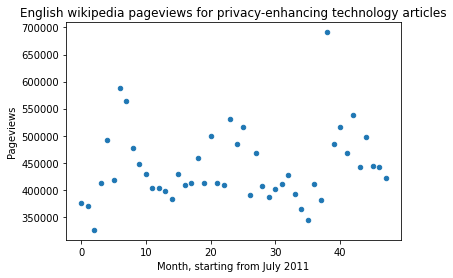

In [8]:
# plot by month
monthly_en_melt.reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views')
plt.xlabel('Month, starting from July 2011')
plt.ylabel('Pageviews')
plt.title('English wikipedia pageviews for privacy-enhancing technology articles')

# Quick preprocessing of articles

Since we have a lot of articles, we want to first remove articles that are of no interest to us, before we can visualize the total dataset correctly

### Get all articles that have a very low amount of views no matter what

In [9]:
low_views = [article for article in monthly_en_melt.index.unique() if (monthly_en_melt.loc[article].views < 100).all()]
print(low_views)
monthly_en_melt = monthly_en_melt.drop(low_views)

['.tor', 'Anonym.OS', 'Ask.fm', 'Candid_(app)', 'Enhanced_privacy_ID', 'I.CX', 'InterPlanetary_File_System', 'Kiwix', 'Library_Genesis', 'Mailfence', 'Netstalking', 'OMEMO', 'Operation_Bayonet_(darknet)', 'Operation_Pacifier', 'Operation_Torpedo', 'PeerBlock', 'Peerio', 'Roger_Dingledine', 'Sarahah', 'Searx', 'Signal_(software)', 'Spring.me', 'Syndie', 'Tails_(operating_system)', 'Tor_Mail', 'Torservers.net', 'Trackbuster', 'UBlock_Origin', 'United_States_v._Stumbo', 'WebTorrent', 'Wireless_onion_router', 'ZeroNet']


### Get all articles that may be outliers

In the same way the original paper found outlier like the hamas article, we want to remove from our dataset sudden changes in pageviews that are not part of our signal.
Since the views an article gets monthly doesn't follow a gaussian distribution, we use IQRs to determine if an article is an outlier rather than just using the 3 standard deviations rule. If the views in a month are higher than the 75th percentile + 3 times the interquartile range, we consider it for manual inspection.

In [10]:
def _is_outlier(article, factor=2):
    """
    Computes if the given entry is an outlier article using IQR in our local dataframe.
    """
    q25, q75 = np.percentile(monthly_en_melt.loc[article].views, 25), np.percentile(monthly_en_melt.loc[article].views, 75)
    iqr = q75 - q25
    cut_off = iqr * factor
    lower, upper = q25 - cut_off, q75 + cut_off
    return ((monthly_en_melt.loc[article].views < lower) | (monthly_en_melt.loc[article].views > upper)).any()

outliers = [article for article in monthly_en_melt.index.unique() if _is_outlier(article)]
print(f'Number of outliers identified: {len(outliers)}')
print(f'Titles: {outliers}')

Number of outliers identified: 29
Titles: ['4chan', 'Anonymous_social_media', 'BNC_(software)', 'Bitmessage', 'Cryptocat', 'Direct_Anonymous_Attestation', 'Disconnect_Mobile', 'Evercookie', 'FLAIM', 'Free_Haven_Project', 'Ghostery', 'HTTPS_Everywhere', 'Hushmail', 'I2P', 'IMule', 'Lightbeam_(software)', 'NetShade', 'Operation_Onymous', 'Privacy_Badger', 'ProtonMail', 'Ricochet_(software)', 'Threema', 'Tor_(anonymity_network)', 'Turtle_F2F', 'Twinkle_(software)', 'Ultrasurf', 'Whisper_(app)', 'Yik_Yak', 'Zfone']


## Manual inspection

In order to verify that our potential outliers should be removed, we manually check each of these articles, the news related to it, to find out if there is an obvious reason for the sudden change in views, and if this reason is related to our signal: privacy enhancing technologies.

The articles we suspect as outliers are:
- **I2P**: Spike happens around the time Silkroad (drug network) moves from tor to I2p
- **IMule**: High variance all around, low views, bump in 2012 probably related to the bump in use of i2p in 2012
- **Operation onymous**: Spikes around the time of operation, an international law enforcement operation targeting darknet markets and other hidden services operating on the Tor network.
- **Tor**: Spike happened when SilkRoad was shut down in october 2013, spike in views was quite large and somewhat unrelated.
- **Bitblinder**: Spike happens in  March 2011 when researchers documented an attack that is capable of revealing the IP addresses of BitTorrent users on the Tor network. 
- **2channel** and **4chan**: Spikes happen in Sep 2015 when the founder of 4chan,  Christopher Poole, formally announced on 21 September 2015 that he had sold the website to the founder of 2channel, 	Hiroyuki Nishimura. 
- **Bitmessage**: Spike happened in Sep 2014 when there were tons of messages being delayed or missing, and also there was word that the network is being attacked by spam. The next update was released then in October 2014 to address these problems.
- **Confide**: The pageviews we got from wikishark don't correspond to the article about the Confide app, but another article with the same name (disambiguation is not working very well on wikishark).

## Outlier removal
We remove the aforementioned articles from our analysis:

In [11]:
manual_outliers = ['4chan','I2P', 'IMule', 'Operation_Onymous', 'Tor_(anonymity_network)', '2channel', 'Bitmessage', 'Confide']
monthly_en_melt= monthly_en_melt.drop(manual_outliers)

# Finally some data visualization
We produce a set of plots to get more of a feel of our data.

### Plotting per article views (total)
This will let us see the page view contribution of each article to the overall signal we are analyzing:

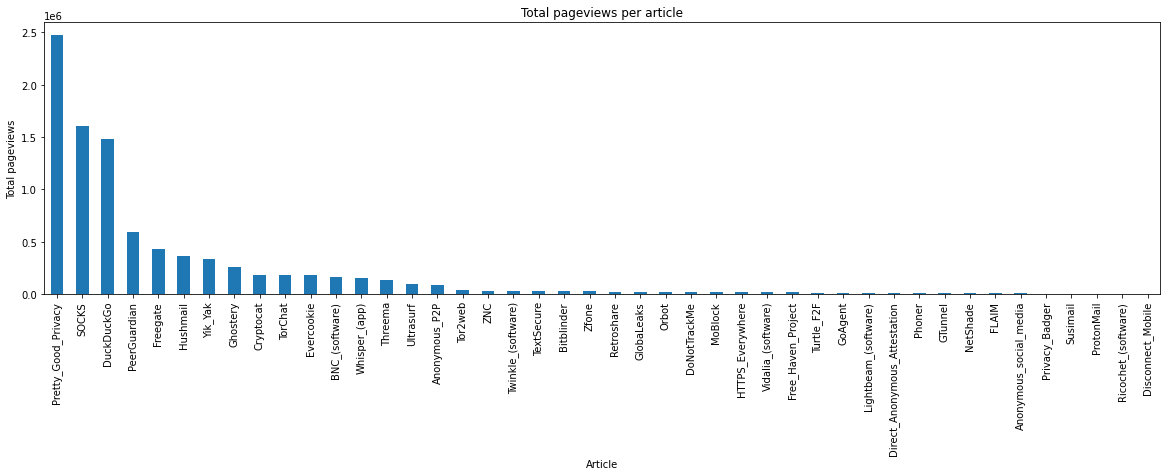

In [12]:
# sort articles by total views in time period
most_views = monthly_en_melt.reset_index().groupby('Article')['views'].sum().sort_values(ascending=False)

# keep the index for the five articles with the most views
head = list(most_views.head(5).index) # a surprise tool that will help us later

# plot the cumulative views for the articles
plt.figure(figsize=(20,5))
most_views.plot.bar()

# labels
plt.title("Total pageviews per article")
plt.ylabel("Total pageviews")
plt.show()

Now that we have removed all those outlier articles, we have a look at what is the real distribution of pageviews for articles that should represent privacy enhancing techniques. We remark that there is still a high gap in the pageviews, for example, the "Pretty Good Privacy" article represents a good percentage of the mass of the distribution.

It might look like this tail is quite long, but this is actually because there is a decent amount of articles that were created during the time period of our analysis, and thus don't accumulate as much total views.

## Plotting total and head 5 articles pageviews
To further investigate just how much the top five articles make up of the signal, we create a plot comparing these two:

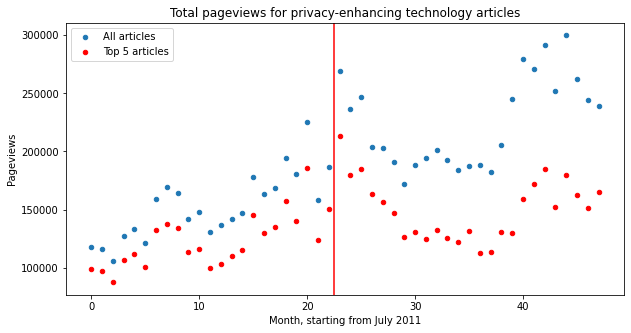

In [13]:
# date of reveal
reveal_index = monthly_en_melt[(monthly_en_melt.date.dt.month == 6) & (monthly_en_melt.date.dt.year == 2013)].month.iloc[0]
fig, ax = plt.subplots(sharey=True, figsize=(10,5))

# plot cumulative page views for all the articles in our analysis
monthly_en_melt.reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views',ax=ax,label='All articles')

# plot cumulative page views for the top five contributors of our signal
monthly_en_melt.loc[head].reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views',ax=ax,c='r',label='Top 5 articles')

# plot reveal line between may and june 2011
plt.axvline(reveal_index-0.5,c='r')

# labels, legend
plt.title("Total pageviews for privacy-enhancing technology articles")
plt.xlabel('Month, starting from July 2011')
plt.ylabel('Pageviews')
plt.show()

There seems to be a lot of variance even before the reveal date, with a peak at the reveal date rather than an effect due to the reveal. We see that the top 5 articles have a very high effect on the trend.

Something interesting to note is that in the long term, there seems to be a reversing trend : the pageviews tend to go down until 2016.

## Plotting the pageviews of articles with the most weight

Since the first 5 articles are responsible for a good portion of the trend of the data, we investigate further on these.

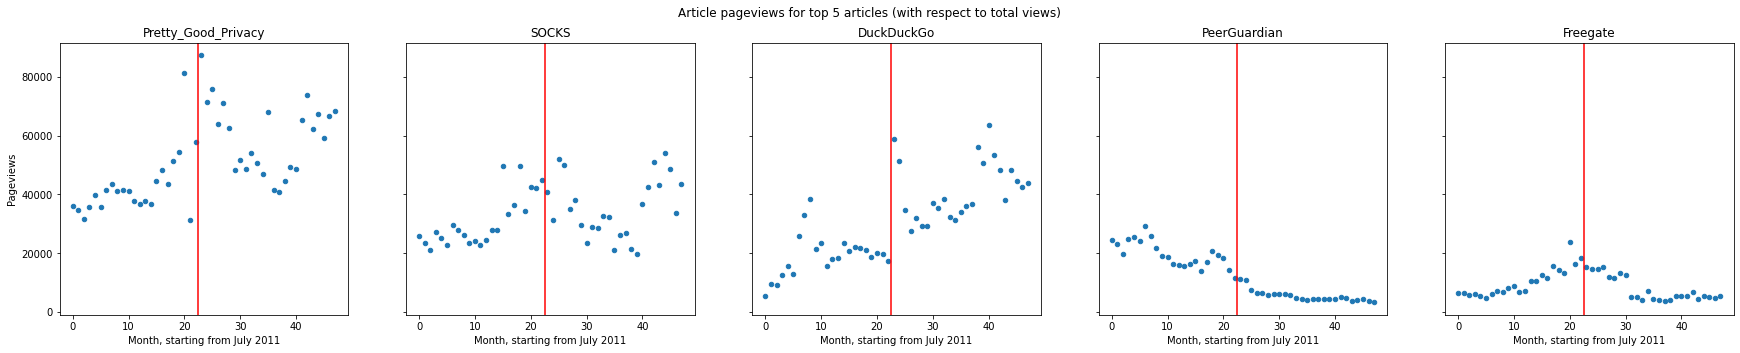

In [14]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5), sharey=True)
for i,ax in enumerate(axs.flatten()):
    
    # plot for each top article
    monthly_en_melt.loc[head[i]].plot.scatter(x='month',y='views',ax=ax)
    
    # plot reveal line between may and june 2011
    ax.axvline(reveal_index-0.5,c='r')
    
    # labels, axis names
    ax.set_title(head[i])
    ax.set_xlabel('Month, starting from July 2011')
    ax.set_ylabel('Pageviews')
plt.suptitle('Article pageviews for top 5 articles (with respect to total views)')
plt.show()

For the DuckDuckGo article, we are able to see quite an important direct impact on the pageviews, starting from the reveal, however, long term it doesn't seem to affect the trend.

For the PGP article, there might be a little bit of an impact, but since there was already a trend of increase it is hard to say.

For the SOCKS, PeerGuardian and Freegate articles we can't identify any lasting trends in views from these visualizations which could be attributed to the reveal.

# Segmented Regression Analysis
Alright, it is time for us to get into the meat and bones of this analysis. We perform a segmented regression analysis on our subset of articles, just like in the original paper we were assigned:

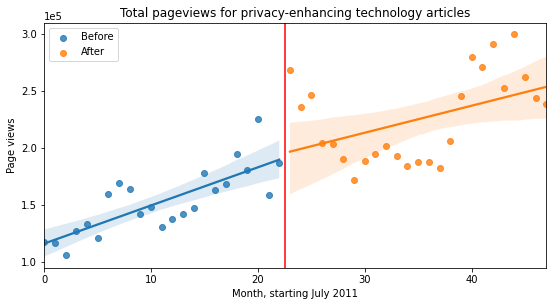

In [15]:
fig,ax = plt.subplots(figsize=(9,4.5))

# take total views
df = monthly_en_melt.groupby('month').sum()

# times before and after the reveal
before = df.loc[:reveal_index-1].reset_index()
after  = df.loc[reveal_index:].reset_index()

# regplot plots both scatter, and regression fit
sns.regplot(x='month', y='views', ax=ax, data=before, label='Before')
sns.regplot(x='month', y='views', ax=ax, data=after, label='After')

# plot reveal line between may and june 2011
plt.axvline(reveal_index-0.5, c='r')

# labels, legend
plt.legend()
plt.title("Total pageviews for privacy-enhancing technology articles")
plt.xlabel('Month, starting July 2011')
plt.ylabel('Page views')

# change number of ticks on y axis
plt.locator_params(axis='y', nbins=7);
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0));

We remark a sudden impact in the following few months, but the long term trend seems to be only slightly impacted by the reveal. It even looks like the usual trend of growth becomes more stable starting from the reveal. It is interesting to compare this to the global wikipedia trend to see how it compares

# Statsmodel Regression Fit

We perform regressional analysis and interpret the coefficients of our model here. We make use of the following model in our analysis (like in the original paper):

$$
Y_t = \beta_0 + \beta_1 \text{time} + \beta_2 \text{intervention} + \beta_3 \text{postslope} + \epsilon
$$

We start out by preparing a dataframe to have the features of the above-mentioned model:

In [16]:
# dataframe containing features required for regression analysis
views = pd.concat([before, after]).views
monthly_views = pd.DataFrame([{'views': views.iloc[i], 'month': i} for i in range(len(views))])

# event occurred during the middle of this 4 year time period
event = reveal_index - 1

# provide feature indicating whether event had occurred yet
monthly_views.loc[:, 'intervention'] = 1
monthly_views.loc[:event, 'intervention'] = 0

# provide feature indicating time-delta from event
monthly_views.loc[:, 'postslope'] = np.abs(monthly_views.month.values - (event+1))
monthly_views.loc[:event, 'postslope'] = 0
monthly_views.head()

,views,month,intervention,postslope
0,117668,0,0,0
1,116440,1,0,0
2,105599,2,0,0
3,126841,3,0,0
4,133116,4,0,0


In [17]:
# perform regression analysis
reg = smf.ols('views ~ month + C(intervention) + postslope', data=monthly_views)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     33.62
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.87e-11
Time:                        23:08:39   Log-Likelihood:                -558.28
No. Observations:                  48   AIC:                             1125.
Df Residuals:                      44   BIC:                             1132.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.159e+05 

The total security page views had an immediate increase of 24780 following June 2013. This is about 12.4% immediate increase. However, the p-value the C(intervention) suggest that this increase may not be statistically significant. 
Moreover, the slop of the increasing trend in the monthly page views have decreased. In this case too, the p-value suggests that the results are not statistically significant.

# Comparison with the global wikipedia pageviews
We will now compare our results with global trends on wikipedia to determine whether there is a difference in trends compared to the global trends seen on wikipedia.

## Segmented Regression analysis
We perform the same analysis as above, using the global page view data. To do so we start out by extracting the global page view data for the English language project. To do so we use the wikimedia API providing these statistics:

In [18]:
def get_pagecounts(language: str, start: str, end: str) -> pd.DataFrame:
    """
    Retrieve the monthly page view aggregates for the given wikipedia language project in the 
    specified time span.
    
    :param language: the string representing the language project the article titlse come from
    :param start: the string representing the starting date of the requested time span
    :param end: the string representing the ending date of the requested time span
    
    :returns: the resulting page views for the given time span
    """
    r = requests.get(f'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{language}.wikipedia/all-sites/monthly/{start}/{end}')
    data = r.json()['items']
    
    # process each month separately
    pagecounts = []
    for month in data:
        
        # add datetime object for ease-of-use
        ts = datetime.datetime.strptime(month['timestamp'], '%Y%m%d%H')
        pagecounts.append({'Timestamp': ts, 'Page views': month['count']})
        
    pagecounts = pd.DataFrame(pagecounts).sort_values(by='Timestamp')
    return pagecounts

monthly_en_all = get_pagecounts('en', '2011063000', '2015063000')
monthly_en_all.head()

,Timestamp,Page views
0,2011-07-01,6571730164
1,2011-08-01,6514500361
2,2011-09-01,5837738935
3,2011-10-01,6974424665
4,2011-11-01,7507641641


In [19]:
date_dict = {pd.Timestamp(date):i for i,date in enumerate(monthly_en_all.Timestamp.unique())}
monthly_en_all['month'] = monthly_en_all.Timestamp.apply(lambda x : date_dict[x])

Now we shall create the same plot as above:

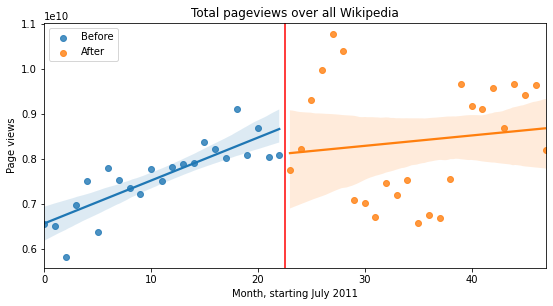

In [20]:
fig,ax = plt.subplots(figsize=(9,4.5))

df = monthly_en_all.copy()

june_first = datetime.datetime(2013,6,1)

# times before and after the reveal
before_all = df[df.month < reveal_index]
after_all  = df[df.month >= reveal_index]

# plot regression lines for both time periods
g = sns.regplot(x='month', y='Page views', data=before_all, label='Before')
g = sns.regplot(x='month', y='Page views', data=after_all, label='After')

# turn numbers back to dates on the axis
ax.get_yaxis().get_major_formatter().set_scientific(True)

# plot reveal line between may and june 2011
plt.axvline(reveal_index-0.5, c='r')

#label axis, legend
plt.legend(loc='upper left')
plt.title("Total pageviews over all Wikipedia")
plt.xlabel('Month, starting July 2011')
plt.ylabel('Page views')
plt.locator_params(axis='y', nbins=6);

We can observe that there seems to be a very wide confidence interval for the regression line after the event. In general: it would seem as though the page views on Wikipedia are trending upward overall. To make a more quantitative analysis we will need to analyze the underlying model of our plot:

## StatsModel regression fit
We use `statsmodels` to further analyze our fitted model:

In [21]:
# event occurred during the middle of this 4 year time period
event = reveal_index - 1
views = monthly_en_all['Page views']
monthly_views_all = pd.DataFrame([{'views': views.iloc[i], 'month': i} for i in range(len(views))])

# provide feature indicating whether event had occurred yet
monthly_views_all.loc[:, 'intervention'] = 1
monthly_views_all.loc[:event, 'intervention'] = 0

# provide feature indicating time-delta from event
monthly_views_all.loc[:, 'postslope'] = np.abs(monthly_views_all.month.values - (event+1))
monthly_views_all.loc[:event, 'postslope'] = 0
monthly_views_all.head()

,views,month,intervention,postslope
0,6571730164,0,0,0
1,6514500361,1,0,0
2,5837738935,2,0,0
3,6974424665,3,0,0
4,7507641641,4,0,0


In [22]:
# let statsmodels do its magic
reg = smf.ols('views ~ month + C(intervention) + postslope', data=monthly_views_all)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     5.753
Date:                Fri, 18 Dec 2020   Prob (F-statistic):            0.00207
Time:                        23:08:39   Log-Likelihood:                -1060.9
No. Observations:                  48   AIC:                             2130.
Df Residuals:                      44   BIC:                             2137.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             6.575e+09 

From these results we must immediately observe that our model doesn't fit the data very well. The $R^2$ is outside the range of values we would have liked to see. If we compare our results with the results achieved in the paper, we see that we attain completely different coefficients from the original author. To validate our data we changed the time span of our analysis temporarily to be the same as in the original study, and we suddenly found a much better model. This raises some concerns about the conclusions of the original study - we would have liked to see an analysis over a longer time span than was performed there.

The p-value for the coefficient fitted to the intervention variable is quite high, i.e. the probablity of this variable not having any impact on the page views is almost 50%. Furthermore the postslope also raises questions as the p-value for this coefficient is also quite high.

# Comparison with the same articles in different languages

### Retrieve wikidata entries for each given article

We proceed by getting the wikidata IDs for each article that remains in our list of articles. We need these so that we can retrieve the equivalent articles in other language projects of Wikipedia.

In [23]:
def get_qid_from_title(title: str, language: str) -> str:
    """
    Gets the Wikidata ID for the given article on the given language project.
    
    :param title: the article title to retrieve qid for
    :param language: the string representing the language project the article title comes from
    
    :returns: the Wikidata ID for the article
    """
    response = requests.get(f'https://{language}.wikipedia.org/w/api.php?'
                            f'action=query&prop=pageprops&titles={title}&redirects&format=json')
    try:
        r = [item for item in response.json()['query']['pages'].values()][0]
        qid = r['pageprops']['wikibase_item']
    except KeyError:
        print(f'Article {title} has no Wikidata ID')
        return None
    return qid

We only retrieve qids for articles we have kept throughout our first analysis, so as to not lose time again during preprocessing, as it is very unlikely that an article never got traction in english (never more than 100 views a month), but did in german wikipedia (given how much more pageviews the english wikipedia gets).

In [24]:
remaining_qids = pd.DataFrame([get_qid_from_title(title, 'en') for title in tqdm(monthly_en_melt.index.unique())])
len(remaining_qids)

44

All articles do have a wikidata entry associated to them, we still have 44 articles.

### Retrieve titles from other languages from our list of qids

In [25]:
def get_title_from_qid(qid,language):
    response = requests.get(f'https://www.wikidata.org/w/api.php?action=wbgetentities&format=xml&props=sitelinks&ids={qid}&sitefilter={language}wiki&format=json')
    try:
        title = response.json()['entities'][qid]['sitelinks'][language+'wiki']['title']
        return title
    except:
        print(f'Article with ID {qid} does not have Wikipedia page in {language}.')
        return None
#example code: get_title_from_qid(qid='Q19675',language='fr')

### Getting the pageviews for titles in other languages

Because the API we had previously used to get the identifier given to articles by wikishark doesn't work consistently when searching for titles in other languages, we had to find a more ad-hoc way : we scrape the webpage that would normally be accessed by humans in order to find the webpage of the article (ex : https://www.wikishark.com/title/fr/DuckDuckGo for DuckDuckGo), and from this webpage, scrap the ID which is found in the source of the webpage. It is not the most pretty way, but it is the only way we found to gather the most amount of articles

In [26]:
import requests
from bs4 import BeautifulSoup

def get_wikishark_addr_from_title(title, language):
    """Returns the wikishark url for the corresponding title and language"""
    DEFAULT_URL = "https://www.wikishark.com"
    URL = "https://www.wikishark.com/search/{} ({})".format(title, language)
    req_text = requests.get(URL).text
    soup = BeautifulSoup(req_text, 'html.parser')
    
    # get list of all articles found
    lis = soup.find_all('li', attrs={'style': 'visibility: visible;'})
    for li in lis:
        for a in li.p.findChildren('a', recursive=False):
            
            # check that the article contains the title, and language
            if language in a.text and title.lower() in a['title'].lower():
                return DEFAULT_URL + a['href']
        
def get_wikishark_id_from_addr(addr, title):
    """Returns the wikishark identifier for the corresponding article title and url address"""
    req_text = requests.get(addr).text
    soup = BeautifulSoup(req_text, 'html.parser')
    
    # find all scripts
    scripts = soup.find_all('script', attrs={'type':"text/javascript"})
    id_script = None
    for script in scripts:
        
        # only keep scripts that contain the title
        if script.string is not None and title.lower() in script.string.lower():
            id_script = script.string
            
    if id_script is not None:
        
        # match all dictionaries inside script
        dic_matcher = r'(\{[^{}]+\})'
        for match in re.findall(dic_matcher, id_script):
            num_matcher = r'\d+'
            
            # match all identifiers (numbers)
            for num in re.findall(num_matcher, match):
                try:
                    return int(num)
                except:
                    continue

def wikishark_id_from_title(title, language):
    """Returns the wikishark identifier for the corresponding title and language"""
    #first get article url
    url = get_wikishark_addr_from_title(title, language)
    if url is None:
        return None
    
    #sleep so as to not overflow their datacenter with requests
    time.sleep(1)
    
    #then get id from url
    return get_wikishark_id_from_addr(url, title)

## Case Study : German wikipedia

We chose to study german wikipedia instead of french wikipedia because german is the second wikipedia language project with respect to pageviews (the first being obviously english).

In [27]:
german_titles = [get_title_from_qid(qid,'de') for qid in np.ravel(remaining_qids.values)]
german_titles = [title for title in german_titles if title is not None]
len(german_titles)

Article with ID Q2544432 does not have Wikipedia page in de.
Article with ID Q16828775 does not have Wikipedia page in de.
Article with ID Q4918761 does not have Wikipedia page in de.
Article with ID Q3708936 does not have Wikipedia page in de.
Article with ID Q18351955 does not have Wikipedia page in de.
Article with ID Q5285912 does not have Wikipedia page in de.
Article with ID Q5416930 does not have Wikipedia page in de.
Article with ID Q5426509 does not have Wikipedia page in de.
Article with ID Q5499866 does not have Wikipedia page in de.
Article with ID Q3238076 does not have Wikipedia page in de.
Article with ID Q5514783 does not have Wikipedia page in de.
Article with ID Q10847331 does not have Wikipedia page in de.
Article with ID Q5949310 does not have Wikipedia page in de.
Article with ID Q1178110 does not have Wikipedia page in de.
Article with ID Q6998318 does not have Wikipedia page in de.
Article with ID Q16927751 does not have Wikipedia page in de.
Article with ID Q175

22

A lot of articles don't exist in german, thus we have only at most 22 articles for which we can get the pageviews.

In [28]:
privacy_de = retrieve_or_compute_pageviews(german_titles,
                              'German',
                              '01/01/2011',
                              '01/01/2016',
                              wikishark_id_from_title,
                              'privacy_de.pkl') 

In [29]:
privacy_de.head()

,2011-01-01,2011-01-02,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-08,2011-01-09,2011-01-10,...,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31
Article,,,,,,,,,,,,,,,,,,,,,
Bouncer,0,90,0,110,0,106,0,98,0,118,...,28,0,28,0,22,0,35,0,30,0
Cryptocat,0,0,0,0,0,0,0,0,0,0,...,12,0,10,0,8,0,15,0,9,0
DuckDuckGo,0,0,0,0,0,0,0,0,0,0,...,270,184,128,197,213,273,267,637,536,311
Ghostery,0,0,0,0,0,1,0,0,0,0,...,82,0,85,0,122,0,107,0,104,0
HTTPS Everywhere,0,0,0,0,0,0,0,0,0,0,...,18,0,18,0,25,0,19,0,33,0


In [30]:
# make columns datetime objects for resampling to work
privacy_de.columns = pd.to_datetime(privacy_de.columns)

# take monthly cumulative
monthly_de = privacy_de.resample('M', axis=1).sum()

### Melting data, and only keep data in the same timeframe as before

In [31]:
# melt dataframe to use dates as entry values rather than columns
monthly_de_melt = pd.melt(monthly_de, value_name='views', var_name='date', ignore_index=False)

#Crop dates from 2011-07-01 to 2015-07-01
start =  datetime.datetime(2011, 7, 1)
end   =  datetime.datetime(2015, 6, 30)
monthly_de_melt = monthly_de_melt.reset_index().set_index('date')[start:end].reset_index().set_index('Article')
monthly_de_melt.head()

,date,views
Article,,
Bouncer,2011-07-31,853
Cryptocat,2011-07-31,0
DuckDuckGo,2011-07-31,5
Ghostery,2011-07-31,0
HTTPS Everywhere,2011-07-31,0


### Add a month feature

In [32]:
date_dict = {pd.Timestamp(date):i for i,date in enumerate(monthly_de_melt.date.unique())}
monthly_de_melt['month'] = monthly_de_melt.date.apply(lambda x : date_dict[x])
monthly_de_melt.head()

,date,views,month
Article,,,
Bouncer,2011-07-31,853,0
Cryptocat,2011-07-31,0,0
DuckDuckGo,2011-07-31,5,0
Ghostery,2011-07-31,0,0
HTTPS Everywhere,2011-07-31,0,0


### Plotting total pageviews views

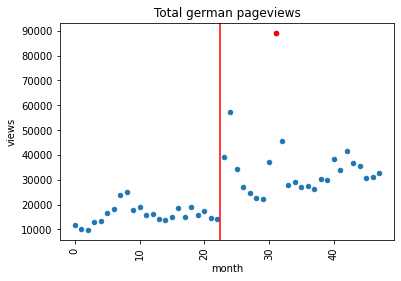

In [33]:
de_views = monthly_de_melt.reset_index().groupby('month').sum().reset_index()

# plot each month 
de_views.plot.scatter(x='month',y='views')

# mark outlier month in red
de_views.iloc[[31]].plot.scatter(x='month',y='views',c='r',ax=plt.gca())

# plot reveal line between may and june 2011
plt.gca().axvline(reveal_index-0.5,c='r')
plt.title('Total german pageviews')
plt.xticks(rotation=90);

This looks reasonably promising, although we might see what can look like at outlier in February 2014, which we marked in red.

### Plotting per article views (total)

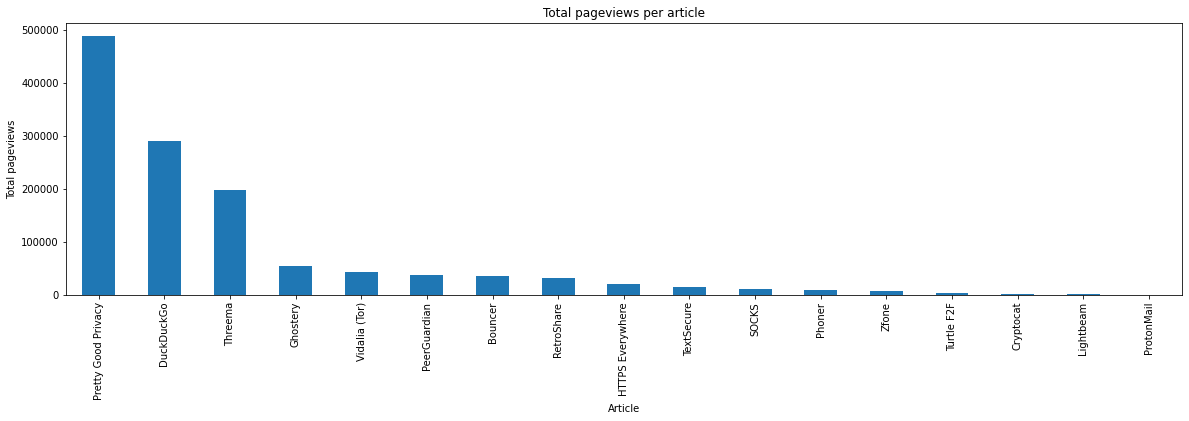

In [34]:
# sort articles by total views in time period
most_views = monthly_de_melt.reset_index().groupby('Article')['views'].sum().sort_values(ascending=False)

# keep the index for the five articles with the most views
head = list(most_views.head(5).index) # a surprise tool that will help us later

# plot the cumulative views for the articles
plt.figure(figsize=(20,5))
most_views.plot.bar()
plt.title("Total pageviews per article")
plt.ylabel("Total pageviews")
plt.show()

### Plotting the pageviews for the top 5 articles

Since the top 5 articles gave us a lot of information in our first study, lets plot them.

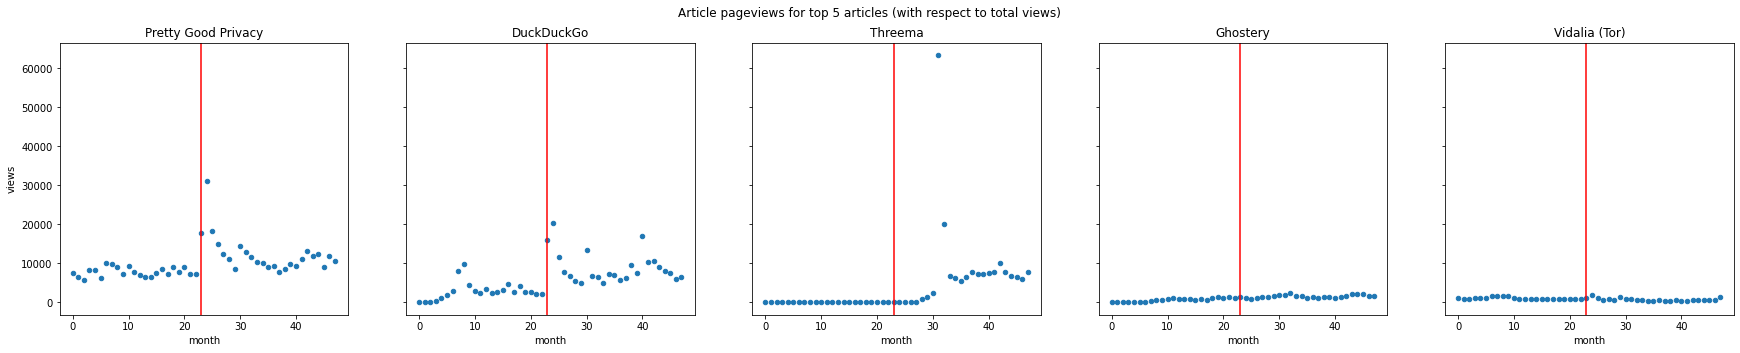

In [35]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5), sharey=True)
for i,ax in enumerate(axs.flatten()):
    
    # plot each of the top 5 articles
    monthly_de_melt.loc[head[i]].plot.scatter(x='month',y='views',ax=ax)
    
    # plot reveal line between may and june 2011
    ax.axvline(reveal_index,c='r')
    ax.set_title(head[i])
plt.suptitle('Article pageviews for top 5 articles (with respect to total views)')
plt.show()

It seems like the Threema article is the reason why we have such a high change in February 2014, why could that be? This date coincides with the endorsement of Threema by the Stiftung Warentest. This event is listed here : https://en.wikipedia.org/wiki/Threema#Reception. Since it is not an effect of the PRISM reveal, we remove this article from our list

In [36]:
no_threema = monthly_de_melt.drop('Threema')

### Plotting the total views with Threema removed

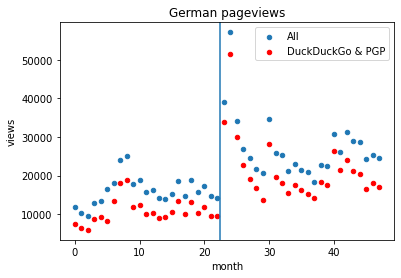

In [37]:
#Plot total views for all articles (without threema)
no_threema.reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views', label='All')

#Plot reveal line between may and june 2011
plt.axvline(reveal_index-0.5)
ax = plt.gca()

#Plot total views for top 2 articles
no_threema.loc[['DuckDuckGo','Pretty Good Privacy']].reset_index().groupby('month').sum().reset_index().plot.scatter(ax=ax,x='month',y='views',c='r', label='DuckDuckGo & PGP')
plt.legend()
plt.title('German pageviews');

This looks interesting, as the sudden impact from the reveal can be observed directly. However, we see another issue, most of the trend can be explained simply by the pageviews of the two articles with the highest amount of pageviews : DuckDuckGo and Pretty Good Privacy. We will try to deal with this issue later on.

### Regression analysis

In [38]:
no_threema.head()

,date,views,month
Article,,,
Bouncer,2011-07-31,853,0
Cryptocat,2011-07-31,0,0
DuckDuckGo,2011-07-31,5,0
Ghostery,2011-07-31,0,0
HTTPS Everywhere,2011-07-31,0,0


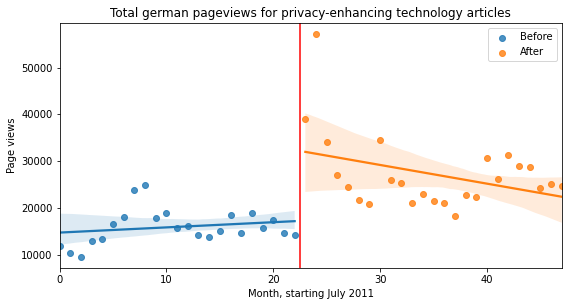

In [39]:
fig,ax = plt.subplots(figsize=(9,4.5))
df = no_threema.groupby('month').sum().reset_index()

# times before and after the reveal
before = df[df.month <  reveal_index].reset_index()
after  = df[df.month >= reveal_index].reset_index()


# regplot plots both scatter, and regression fit
sns.regplot(x='month', y='views', ax=ax, data=before, label='Before')
sns.regplot(x='month', y='views', ax=ax, data=after, label='After')

# plot reveal line between may and june 2011
plt.axvline(reveal_index-0.5, c='r')
plt.legend()
plt.title("Total german pageviews for privacy-enhancing technology articles")

# turn numbers back to dates on the axis
plt.margins(x=0.5)
plt.xlabel('Month, starting July 2011')
plt.ylabel('Page views')

#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.locator_params(axis='y', nbins=7);

## StatsModel regression fit
We use `statsmodels` to further analyze our fitted model:

In [40]:
# dataframe containing features required for regression analysis
de_views = pd.concat([before, after]).views
monthly_de_views = pd.DataFrame([{'views': de_views.iloc[i], 'month': i} for i in range(len(de_views))])

# event occurred during the middle of this 4 year time period
event = reveal_index-1

# provide feature indicating whether event had occurred yet
monthly_de_views.loc[:, 'intervention'] = 1
monthly_de_views.loc[:event, 'intervention'] = 0

# provide feature indicating time-delta from event
monthly_de_views.loc[:, 'postslope'] = np.abs(monthly_de_views.month.values - (event+1))
monthly_de_views.loc[:event, 'postslope'] = 0
monthly_de_views.head()

,views,month,intervention,postslope
0,11845,0,0,0
1,10327,1,0,0
2,9620,2,0,0
3,12979,3,0,0
4,13369,4,0,0


In [41]:
# perform regression analysis
reg = smf.ols('views ~ month + C(intervention) + postslope', data=monthly_de_views)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     15.85
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           3.96e-07
Time:                        23:09:04   Log-Likelihood:                -483.86
No. Observations:                  48   AIC:                             975.7
Df Residuals:                      44   BIC:                             983.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.477e+04 

This $R^2$ score is not very high, which means that the linear fit cannot explain properly the variance we see here. Moreover, the p-value for the $\beta_1$ coefficient is 0.562 which is very high.

### Also removing DuckDuckGo and Pretty Good Privacy ?

An issue we have seen before is that the "DuckDuckGo" and "Pretty Good Privacy" articles are able to explain most of the trend in the german pageviews. Here, we try removing them, to see if there is a trend among the articles that have a lower amount of views.

In [42]:
no_big_article = monthly_de_melt.drop(['Threema', 'DuckDuckGo', 'Pretty Good Privacy'])

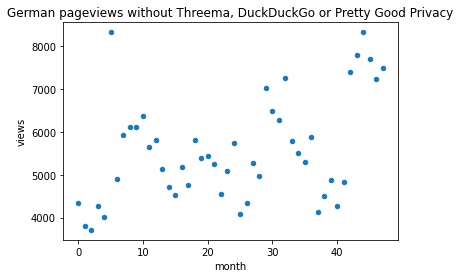

In [43]:
no_big_article.reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views')
plt.title('German pageviews without Threema, DuckDuckGo or Pretty Good Privacy');

We can't see any visual trend in this data, so we do not engage further in this experiment.

# Other Experiments :

We have tried various other ways for dealing with data with a high difference in pageviews, i.e. to not fit our whole hypothesis on the 3 articles that have the most views. The two following experiments didn't lead to significant conclusions but we leave them here for completeness.

## First Experiment : Standardizing per article

In this part, we standardize the views of each articles, thus giving the same weights to all articless.

In [44]:
def standardize(x):
    mean = monthly_en_melt.reset_index().groupby('Article').mean()['views'].loc[x['Article']]
    std  = monthly_en_melt.reset_index().groupby('Article').std()['views'].loc[x['Article']]
    std = std if std != 0 else 1
    return (x['views'] - mean)/std

# apply standardization over all articles
monthly_en_melt = monthly_en_melt.reset_index()
monthly_en_melt['standardized'] = monthly_en_melt.apply(standardize,axis=1)

# reset index back to articles
monthly_en_melt = monthly_en_melt.set_index('Article')
monthly_en_melt.head()

,date,views,month,standardized
Article,,,,
Anonymous_P2P,2011-07-31,1879,0,-0.011564
Anonymous_social_media,2011-07-31,0,0,-0.508897
BNC_(software),2011-07-31,3439,0,0.216717
Bitblinder,2011-07-31,995,0,2.128790
Cryptocat,2011-07-31,0,0,-1.643853


### Standardized vs total views

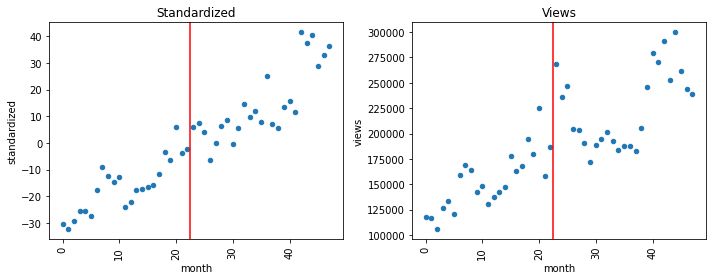

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

# plot reveal line between may and june 2011
axs[0].axvline(reveal_index-0.5,c='r')
axs[1].axvline(reveal_index-0.5,c='r')

axs[0].set_title('Standardized')
axs[1].set_title('Views')

# plot standardized and normal views
monthly_en_melt.groupby('month').sum().reset_index().plot.scatter(x='month', y='standardized', ax=axs[0], rot=90)
monthly_en_melt.groupby('month').sum().reset_index().plot.scatter(x='month', y='views',ax=axs[1],rot=90)

plt.tight_layout()

Given that we have a high amount of articles, even with our quick preprocessing, we have too many articles that have a low amount of views, which makes them inherently have more variance, so it is unfair to give as much weight to these articles as to the other ones.

## Second Experiment : Stratification

Instead of analyzing a single group of articles that have highly different views, we can select groups of articles that have similar viewcounts, and analyze them together.
Given that our distribution of total pageviews per articles can be considered as heavy-tailed, we probably don't want equal width or equal frequency discretization. Instead we opt for clustering to divide our articles into multiple groups, by creating clusters based on the total amount of views.

In [46]:
sorted_views = monthly_en_melt.reset_index().groupby('Article').sum().sort_values('views',ascending=False)
vals = np.log(sorted_views['views'].values.reshape((-1,1))) #Use log scales values because they are too far away

### Selecting number of clusters

Since we don't know exactly how many groups we want to define, we will use the silhouette score and the elbow method to help us.

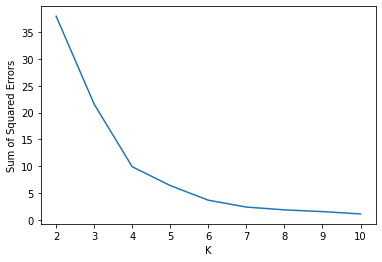

In [47]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(vals)

Text(0, 0.5, 'Silhouette score')

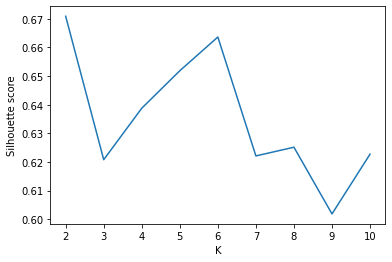

In [48]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(vals)
    # Get the Silhouette score
    score = silhouette_score(vals, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

Given that there is now particular elbow, we take the value with the best silhouette score, K = 5.

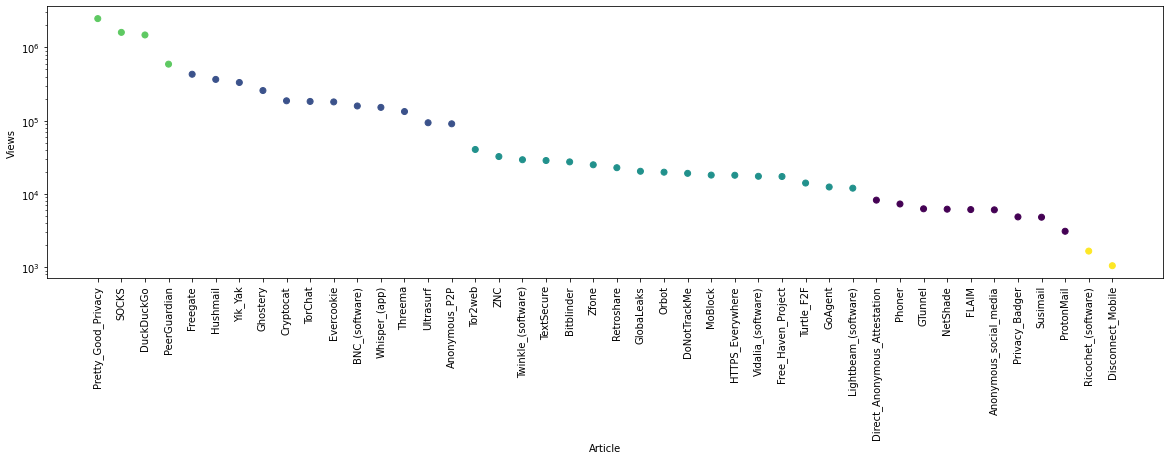

In [49]:
NUM_CLUSTERS = 5

# fit clustering to data
clustering = KMeans(n_clusters=NUM_CLUSTERS).fit(vals)

plt.figure(figsize=(20,5))

#plot views with the right label
plt.scatter(x=range(len(sorted_views)),y=sorted_views['views'], c=clustering.labels_)

#set scale and labels
plt.gca().set_yscale('log')
plt.xlabel('Article')
plt.ylabel('Views')

#set and rotate xticks
plt.gca().set_xticks(range(len(sorted_views)))
plt.gca().set_xticklabels(sorted_views.index, rotation=90)

#set group of all articles using clustering labels
sorted_views['group'] = clustering.labels_
monthly_en_melt['group'] = sorted_views['group']

## Plotting per group

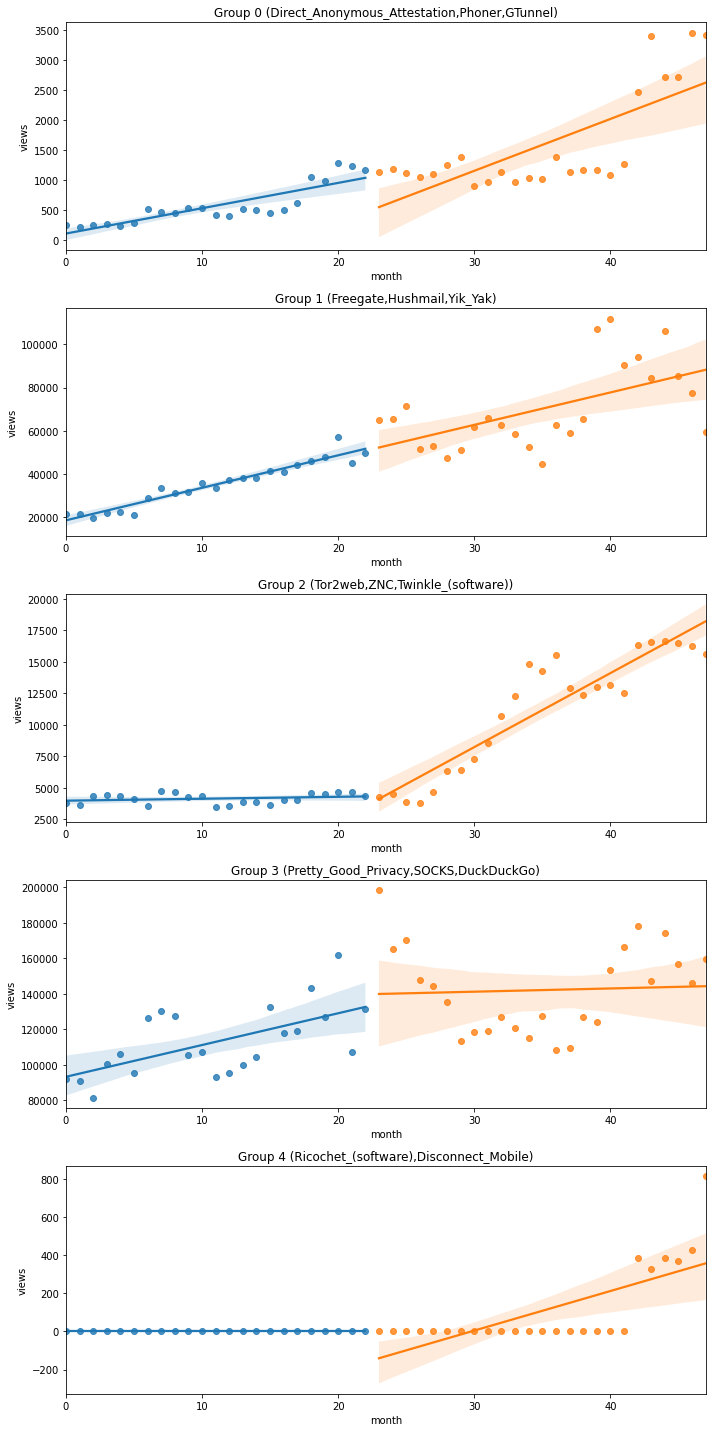

In [50]:
reveal = datetime.date(2013,6,5)
fig, axs = plt.subplots(nrows=NUM_CLUSTERS, figsize=(10,20))

for g,ax in zip(range(len(monthly_en_melt.group.unique())),axs.flatten()):
    
    # group by date, select the group
    selected = monthly_en_melt[monthly_en_melt['group'] == g]
    df = selected.groupby('month').sum().reset_index()
    
    # separate in before and after reveal date
    before = df[df.month < reveal_index].reset_index()
    after  = df[df.month >= reveal_index].reset_index()
    
    # plot both regression plots 
    sns.regplot(x='month',y='views',ax=ax,data=before)
    sns.regplot(x='month',y='views',ax=ax,data=after)
    
    # edit title to top article names
    sample = selected.reset_index().groupby('Article').sum().sort_values('views', ascending=False).head(3).index
    sample_str = ','.join(sample)
    ax.set_title(f'Group {g} ({sample_str})')
plt.tight_layout()

Unfortunately, we are not very comfortable on interpreting these results, since they show many different trends, so we would have to go through each individual article and verify what causes the trend, so we also stopped with this analysis. Another issue we thought of is that the clusters we would find on other languages of wikipedia would be different so it would be hard to compare a general trend given that we find no general trend here.

# French wikipedia pageview analysis

We tried analyzing the french wikipedia, but could not find any particular trend change from the reveal.

In [51]:
french_titles  = [get_title_from_qid(qid,'fr') for qid in np.ravel(remaining_qids.values)]
french_titles = [title for title in french_titles if title is not None]
french_titles

Article with ID Q895141 does not have Wikipedia page in fr.
Article with ID Q4918761 does not have Wikipedia page in fr.
Article with ID Q3708936 does not have Wikipedia page in fr.
Article with ID Q5416930 does not have Wikipedia page in fr.
Article with ID Q5426509 does not have Wikipedia page in fr.
Article with ID Q3238076 does not have Wikipedia page in fr.
Article with ID Q5514783 does not have Wikipedia page in fr.
Article with ID Q10847331 does not have Wikipedia page in fr.
Article with ID Q1178110 does not have Wikipedia page in fr.
Article with ID Q6998318 does not have Wikipedia page in fr.
Article with ID Q16927751 does not have Wikipedia page in fr.
Article with ID Q2088644 does not have Wikipedia page in fr.
Article with ID Q7649085 does not have Wikipedia page in fr.
Article with ID Q15735491 does not have Wikipedia page in fr.
Article with ID Q1782317 does not have Wikipedia page in fr.
Article with ID Q16927887 does not have Wikipedia page in fr.
Article with ID Q1821

['P2P anonyme',
 'Média social anonyme',
 'Cryptocat',
 'Disconnect (logiciel)',
 'DoNotTrackMe',
 'DuckDuckGo',
 'Free Haven Project',
 'Ghostery',
 'GlobaLeaks',
 'HTTPS Everywhere',
 'Hushmail',
 'Lightbeam',
 'PeerGuardian',
 'Pretty Good Privacy',
 'Privacy Badger',
 'ProtonMail',
 'RetroShare',
 'Ricochet (logiciel)',
 'SOCKS',
 'TextSecure',
 'Threema',
 'TorChat',
 'Turtle F2F',
 'Twinkle',
 'Ultrasurf',
 'Zfone']

### Retrieve pageviews

In [52]:
privacy_fr = retrieve_or_compute_pageviews(french_titles,
                              'French',
                              '01/01/2011',
                              '01/01/2016',
                              wikishark_id_from_title,
                              'privacy_fr.pkl') 

### Plot total monthly pageviews

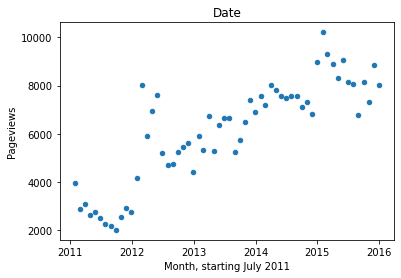

In [53]:
# make columns datetime objects for resampling to work
privacy_fr.columns = pd.to_datetime(privacy_fr.columns)

# take monthly cumulative
monthly_fr = privacy_fr.resample('M', axis=1).sum()
monthly_fr.sum().to_frame().reset_index().plot.scatter(x='index',y=0)
plt.xlabel('Month, starting July 2011')
plt.ylabel('Pageviews')
plt.title('Date');

These pageviews don't seem to show any particular trend starting from the reveal.

### Melt dataframe

In [54]:
monthly_fr_melt = pd.melt(monthly_fr, value_name='views', var_name='date', ignore_index=False)

In [55]:
date_dict = {pd.Timestamp(date):i for i,date in enumerate(monthly_fr_melt.date.unique())}
monthly_fr_melt['month'] = monthly_fr_melt.date.apply(lambda x : date_dict[x])

### Find Distribution of pageviews by article

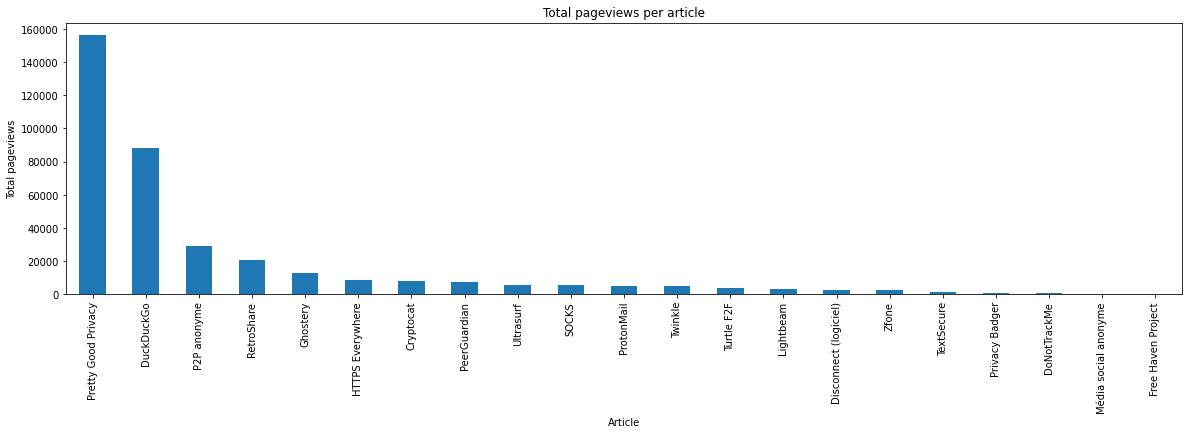

In [56]:
# sort articles by total views in time period
most_views = monthly_fr_melt.reset_index().groupby('Article')['views'].sum().sort_values(ascending=False)

# keep the index for the five articles with the most views
head = list(most_views.head(5).index) # a surprise tool that will help us later

# plot the cumulative views for the articles
plt.figure(figsize=(20,5))
most_views.plot.bar()
plt.title("Total pageviews per article")
plt.ylabel("Total pageviews")
plt.show()

### Plot pageviews for the top 5 articles

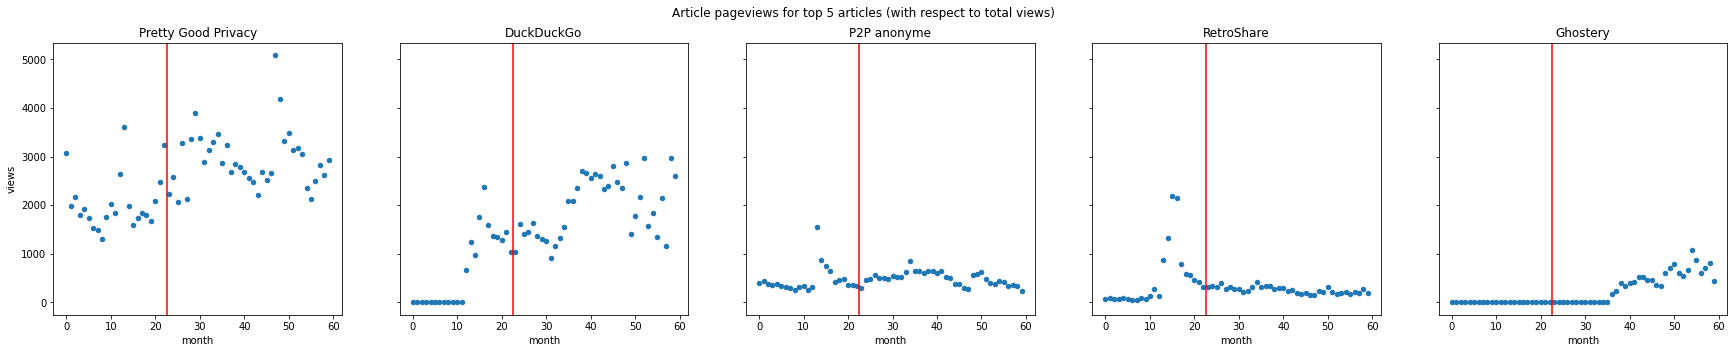

In [57]:
fig, axs = plt.subplots(ncols=5, figsize=(30,5), sharey=True)
for i,ax in enumerate(axs.flatten()):
    
    # for each of the top 5 article, plot it
    monthly_fr_melt.loc[head[i]].plot.scatter(x='month',y='views',ax=ax)
    
    # plot reveal line between may and june 2011
    ax.axvline(reveal_index-0.5,c='r')
    ax.set_title(head[i])
plt.suptitle('Article pageviews for top 5 articles (with respect to total views)')
plt.show()

The top 5 articles don't show any particular trend starting from the reveal date.

## Removing the two biggest articles with respect to pageviews

Since no other experiment managed to show any particular trend starting from the reveal date, we hope that removing the biggest articles, may lead to the articles with lower pageviews to show a particular trend.

In [58]:
no_big_fr = monthly_fr_melt.drop(['DuckDuckGo', 'Pretty Good Privacy'])

Text(0.5, 1.0, 'French pageviews without "DuckDuckGo" and "Pretty Good Privacy" articles')

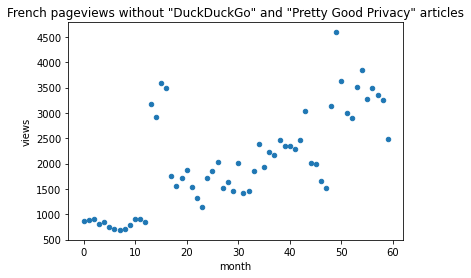

In [59]:
no_big_fr.reset_index().groupby('month').sum().reset_index().plot.scatter(x='month',y='views')
plt.title('French pageviews without "DuckDuckGo" and "Pretty Good Privacy" articles')

This doesn't lead to anything significant, hence why we didn't include it in the rest of our analysis.